In [1]:
%load_ext autoreload
%autoreload 2
# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

import torch
from torch import nn
from torch.nn.init import calculate_gain
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f'CUDA {i}: {torch.cuda.get_device_name(i)}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

CUDA 0: NVIDIA GeForce GTX 1650 Ti


In [2]:
from models import MLP_PINN
net = MLP_PINN(N_layers=8, width=32, activation=nn.Softplus(30), last_activation=nn.Softplus(30)).to(device)
net.loss_lambda['loss_normal'] = 0.1
net.loss_lambda['loss_cosine_similarity'] = 0.1
net.loss_lambda['loss_residual'] = 0.1
net.loss_lambda['loss_residual_constraint'] = 0.1

In [3]:
import os
from utils.dataset_generator import ImplicitDataset, batch_loader

dataset_name = '../datasets/box_1f0_gyroid_4pi'
output_stl = dataset_name+'.stl'
train_dataset = ImplicitDataset.from_file(file=dataset_name+'_train.npz', device=device)

# filter out discontinous points
# grads = train_dataset.grads
# norm_grad = torch.linalg.norm(grads, dim=1)
# mark = torch.logical_and(norm_grad > 0.9, norm_grad < 1.001)
# train_dataset.grads = grads[mark]
# train_dataset.points = train_dataset.points[mark]
# train_dataset.sdfs = train_dataset.sdfs[mark]
# train_dataset.points.requires_grad_(True)

print(train_dataset)
residual_points = train_dataset.points.clone()

[pyigl_import] module igl not found. trying to import pyigl
ImplicitDataset (64000 points)


In [4]:
from utils.callback_scheduler import CallbackScheduler
from utils.residual_sampler import ResidualSampler

# Residual Sampler initialzation
residual_sampler = ResidualSampler(net, num_grid_points=100*100*100)
residual_sampler.set_bounds_from_points(train_dataset.points)

# Optimizer initialization
torch.nn.utils.clip_grad_norm_(net.parameters(), 10.0)
optimizer=torch.optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-6, amsgrad=False)
lr_scheduler = CallbackScheduler([
    CallbackScheduler.reduce_lr(0.5),
    CallbackScheduler.nothing(),
    CallbackScheduler.reduce_lr(0.5),
    CallbackScheduler.nothing(),
    # CallbackScheduler.adaptive_residual_sampling(num_points=10000),
    # CallbackScheduler.adaptive_residual_sampling(num_points=10000, expand_scale_ratio=0.5),
    # CallbackScheduler.adaptive_residual_sampling(num_points=10000),
    # CallbackScheduler.adaptive_residual_sampling(num_points=10000, expand_scale_ratio=0.5),
    # CallbackScheduler.adaptive_residual_sampling(num_points=10000),
], optimizer=optimizer, residual_points=residual_points, residual_sampler=residual_sampler, model=net, eps=1e-7, patience=300)

In [5]:
from utils.dataset_generator import batch_loader
from math import ceil

batch_size = 10000
lr_step = 500

NUM_BATCH = int(ceil(len(train_dataset.points) / batch_size))
MAX_EPOCHS = int(lr_step * (len(lr_scheduler)+1))
PRINT_EVERY_EPOCH = int(MAX_EPOCHS // 10)
NUM_TRAIN_SAMPLES = len(train_dataset)

print(f'Max epoch: {MAX_EPOCHS} (PRINT: {PRINT_EVERY_EPOCH}, NUM_BATCH: {NUM_BATCH})')

try:
    epoch = 0
    while epoch < MAX_EPOCHS:
        #loss = torch.empty((1,), device=device, requires_grad=True)
        for points, sdfs in batch_loader(train_dataset.points, train_dataset.sdfs, batch_size=batch_size):
            
            lr_scheduler.optimizer.zero_grad()
            
            points.requires_grad_(True)
            lr_scheduler.residual_points.requires_grad_(True)

            loss = net.loss(points, sdfs, lr_scheduler.residual_points)
            #loss = loss + points.shape[0] * _loss

            #loss = loss / NUM_TRAIN_SAMPLES
            loss.backward()
            lr_scheduler.optimizer.step(lambda: loss)
        
        lr_scheduler.step_when((epoch % lr_step) == lr_step - 1, verbose=True)
        if epoch % PRINT_EVERY_EPOCH == 0:
            print(f'#{epoch} {net.print_loss()}')
        
        epoch += 1
    print(f'#{epoch} {net.print_loss()}\nSuccess')
except KeyboardInterrupt as e:
    print('Bye bye')



Max epoch: 3000 (PRINT: 300, NUM_BATCH: 7)
#0 Loss: na 0.011081 0.903719 na na na 
#300 Loss: na 0.000481 0.015295 na na na 
[callback scheduler]:  do_nothing
#600 Loss: na 0.000411 0.013127 na na na 
#900 Loss: na 0.000535 0.006748 na na na 
[callback scheduler]:  reduce_learning_rate
#1200 Loss: na 0.000337 0.005710 na na na 
[callback scheduler]:  do_nothing
#1500 Loss: na 0.000322 0.005407 na na na 
#1800 Loss: na 0.000442 0.006162 na na na 
[callback scheduler]:  reduce_learning_rate
#2100 Loss: na 0.000308 0.005010 na na na 
#2400 Loss: na 0.000289 0.004756 na na na 
[callback scheduler]:  do_nothing
#2700 Loss: na 0.000272 0.004268 na na na 
#3000 Loss: na 0.000244 0.004526 na na na 
Success


In [7]:
torch.save(net.state_dict(), f'{dataset_name}-PINN.pth')
#torch.save(net.state_dict(), 'PINN_3000.pth')

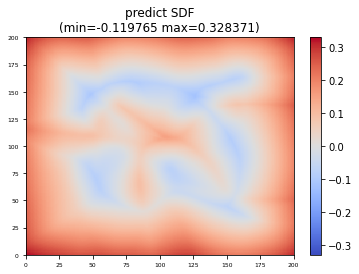

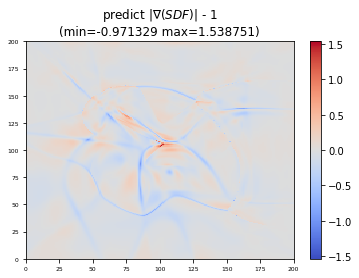

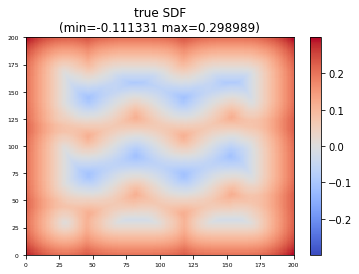

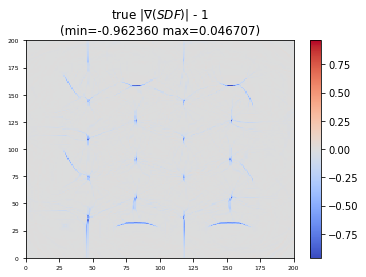

In [6]:
from utils.visualizer import SDFVisualize
net.to(device)
visualize = SDFVisualize(z_level=0.0, scale_offset=0.2, nums=200, device=device)
visualize.from_nn(net, bounds_from_mesh=output_stl)
visualize.from_mesh(output_stl)

In [8]:
from utils.dataset_generator import TestDataset, run_batch
test_dataset = TestDataset(dataset_name+'_test.npz', device=device)
kwarg = {'reducer': torch.mean, 'batch_size': 10000}
#print('Train residual: ', net.test_residual(train_dataset.points).cpu().detach().numpy())
print('Test uniform SDFS: ', run_batch(net.test, test_dataset.uniform.points, test_dataset.uniform.sdfs, **kwarg).cpu().detach().numpy())
print('Test uniform residual:', run_batch(net.test_residual, test_dataset.uniform.points, **kwarg).cpu().detach().numpy())
print('Test uniform norm grads: ', run_batch(net.test_norm_gradient, test_dataset.uniform.points, test_dataset.uniform.norm_grads, **kwarg).cpu().detach().numpy())
print('Test random SDFS: ', run_batch(net.test, test_dataset.random.points, test_dataset.random.sdfs, **kwarg).cpu().detach().numpy())
print('Test random residual: ', run_batch(net.test_residual, test_dataset.random.points, **kwarg).cpu().detach().numpy())
#print('Actual uniform residual: ', torch.mean((test_dataset.uniform.gradients - 1)**2).cpu().detach().numpy())

Test uniform SDFS:  0.0018243573
Test uniform residual: 0.072177164
Test uniform norm grads:  0.018184725
Test random SDFS:  0.07323292
Test random residual:  0.4165462
